# Store Sales 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from xgboost import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Importing CSV

In [2]:
df_train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
df_test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
df_store = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

# df_oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv/
# df_events = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
# df_trans = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

## Dropping Id

In [3]:
id_ = df_test.id
df_test = df_test.drop(['id'], axis=1)
df_train = df_train.drop(['id'], axis=1)

# Data Analysis

Both events and store has the *"type"* columns, so after careful understanding and some guts feeling i thought of dropping the *type* columns in the store one and then merge the both to the train and test DataFrame, so it's my initial guess---

P.S:- and that was wrong the date seems to be odd and both type represents differnet values or events, so dates might not be a good way to concat the events with the test and train df's

In [4]:
df_train = df_train.merge(df_store, on='store_nbr')
df_test = df_test.merge(df_store, on='store_nbr')

## Dropping Missing Values

In [5]:
df_train = df_train.dropna()
df_train.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

# Feature Engineering

## Conveting the cat data to numerical

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
 5   city         object 
 6   state        object 
 7   type         object 
 8   cluster      int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 206.1+ MB


In [7]:
cat_cols = ['family', 'city', 'state', 'type']

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


for col in cat_cols:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

In [9]:
le.classes_

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

## Separating Date to day year and months

In [10]:
def date_to_cols(data, splitter):
    splitted = pd.DataFrame()
    splitted = data.date.str.split(splitter, expand=True)
    splitted.rename(columns={0:'year', 1:'month', 2:'day'},inplace=True)
    data = pd.concat([splitted, data], axis=1)
    data.drop(['date'],axis=1, inplace=True)

    return data

In [11]:
splitter = '-'
df_train = date_to_cols(df_train, splitter)

In [12]:
df_test = date_to_cols(df_test, splitter)

In [13]:
df_train['year'] = df_train['year'].astype(int)
df_train['month'] = df_train['month'].astype(int)
df_train['day'] = df_train['day'].astype(int)

df_test['year'] = df_test['year'].astype(int)
df_test['month'] = df_test['month'].astype(int)
df_test['day'] = df_test['day'].astype(int)

# Seeing Corr

Only *"family"* and *"onpromontion"* has some linear relation 

In [14]:
df_train.corr().round(2)['sales']

year           0.08
month          0.02
day           -0.01
store_nbr      0.04
family        -0.11
sales          1.00
onpromotion    0.43
city           0.05
state          0.07
type          -0.10
cluster        0.04
Name: sales, dtype: float64

In [15]:
df_train.head()

,year,month,day,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013,1,1,1,0,0.0,0,18,12,3,13
1,2013,1,1,1,1,0.0,0,18,12,3,13
2,2013,1,1,1,2,0.0,0,18,12,3,13
3,2013,1,1,1,3,0.0,0,18,12,3,13
4,2013,1,1,1,4,0.0,0,18,12,3,13


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'store_nbr'}>,
        <Axes: title={'center': 'family'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'onpromotion'}>,
        <Axes: title={'center': 'city'}>,
        <Axes: title={'center': 'state'}>],
       [<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'cluster'}>, <Axes: >]], dtype=object)

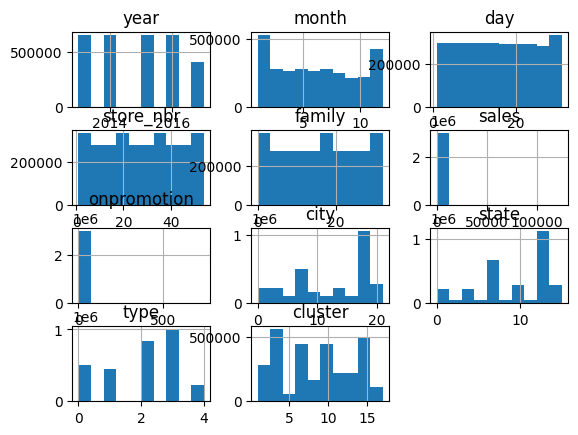

In [16]:
df_train.hist()

<Axes: ylabel='sales'>

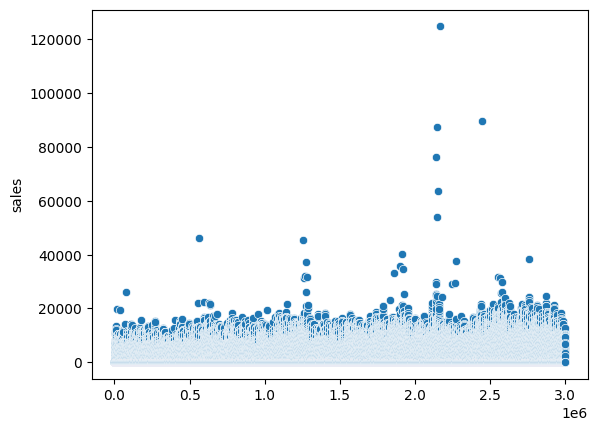

In [17]:
sns.scatterplot(df_train['sales'])

In [18]:
# pd.plotting.scatter_matrix(df_train)

# Separating Data

In [19]:
X = df_train.drop(['sales'], axis=1)
y = df_train['sales']

# Model Selection

In [20]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Testing Model

## Extra Tree

In [21]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_jobs=-1)

etr.fit(X, y)

ExtraTreesRegressor(n_jobs=-1)

In [22]:
# mean_squared_error(y_test, etr.predict(X_test))

## Random Forest Regressor

In [23]:
# from sklearn.ensemble import RandomForestRegressor

# re = RandomForestRegressor(n_jobs=-1)

In [24]:
# re.fit(X_train, y_train)

In [25]:
# mean_squared_error(y_test, re.predict(X_test))

## Neural Network

In [26]:
# model_NN = Sequential()

In [27]:
# model_NN.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# model_NN.add(Dense(256, kernel_initializer='normal',activation='relu'))
# model_NN.add(Dense(256, kernel_initializer='normal',activation='relu'))
# model_NN.add(Dense(256, kernel_initializer='normal',activation='relu'))

# model_NN.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [28]:
# model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model_NN.summary()

In [29]:
# x_train = np.asarray(X_train).astype('float32')
# x_test = np.asarray(X_test).astype('float32')

# Y_test = np.asarray(y_test).astype('float32')
# Y_train = np.asarray(y_train).astype('float32')

# X_ = np.asarray(X).astype('float32')
# y_ = np.asarray(y).astype('float32')

In [30]:
# model_NN.fit(X_, y_, epochs=3, validation_split=0.2, shuffle=True)

## XGBoost

In [31]:
X.dtypes

year           int64
month          int64
day            int64
store_nbr      int64
family         int64
onpromotion    int64
city           int64
state          int64
type           int64
cluster        int64
dtype: object

In [32]:
# model_xgboost = XGBRegressor()

# model_xgboost.fit(X, y)

In [33]:
# mean_squared_error(y_test, model_xgboost.predict(X_test))

# Using the Extra Tree

This model performs best, in this scenario

In [34]:
df_test.shape

(28512, 10)

In [35]:
# pred = model_NN.predict(np.asarray(df_test).astype('float32'))
# pred = pred.flatten()

In [36]:
pred = etr.predict(df_test)

In [37]:
out = pd.DataFrame({'id':id_, 'sales':pred})

In [38]:
out.to_csv('submission.csv', index=False)
print("Submitted")

Submitted


# Note

I am learner, so if u find any error and has any kind ot suggestion, please do enliten me.. Thx 